# Playground 
**Tuesday, Nov 13, 2018**

- Documentation site of WFDB: http://wfdb.readthedocs.io/

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

import wfdb
from wfdb import processing

%matplotlib inline

## Reading records and annotations

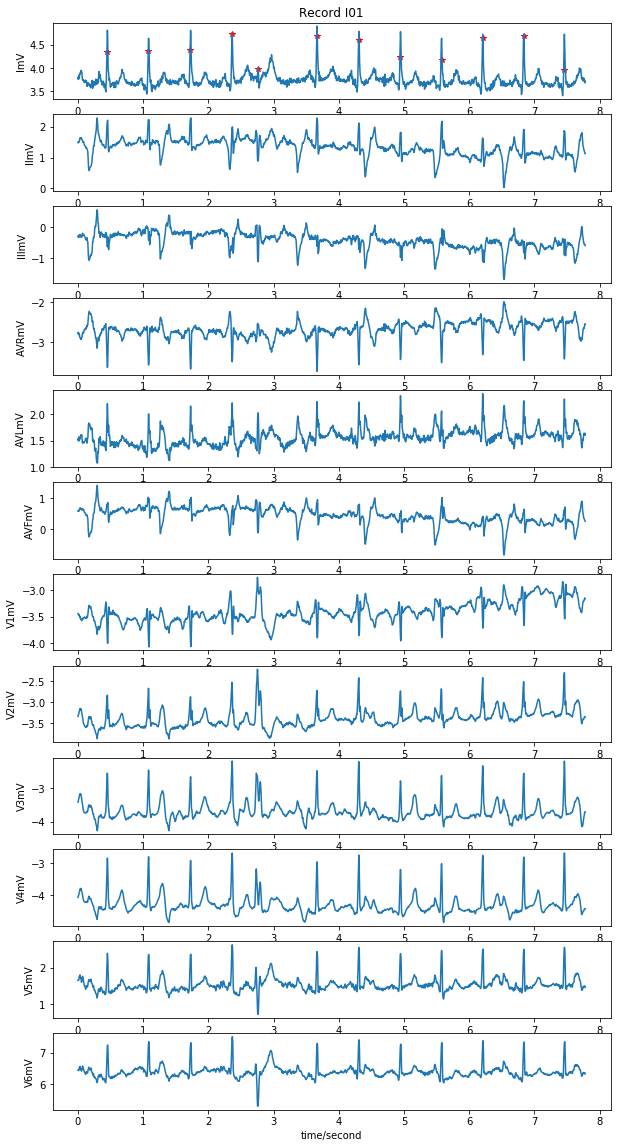

{'record_name': 'I01', 'n_sig': 12, 'fs': 257, 'counter_freq': None, 'base_counter': None, 'sig_len': 2000, 'base_time': None, 'base_date': None, 'comments': ['<age>: 65 <sex>: F <diagnoses> Coronary artery disease, arterial hypertension', 'patient 1', 'PVCs, noise'], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[ 3.79411765,  1.49346405, -0.30392157, ..., -4.07189542,
         1.65359477,  6.44444444],
       [ 3.75816993,  1.47712418, -0.28431373, ..., -4.05228758,
         1.66013072,  6.44771242],
       [ 3.76470588,  1.49673203, -0.27124183, ..., -4.01633987,
         1.67320261,  6.44771242],
       ...,
       [ 3.70588235,  1.15686275, -0.55228758, ..., -4.4248366 ,
         1.50326797,  6.36601307],
       [ 3.68300654,  1.12745098, -0.55882353, ..., -4.42156863,
         1.49019608,  6.34313725],
       [ 3.71568627,  1.12745098, -0.59150327, ..., -4.4248366 ,
         1.46405229,  6.32352941]]), 'd_signal': None

In [47]:
# Demo 1 - Read a wfdb record using the 'rdrecord' function into a wfdb.Record object.
# Plot the signals, and show the data.
record = wfdb.rdrecord('../rawData/I01', sampto=2000) 
annotation = wfdb.rdann('../rawData/I01', 'atr', sampto = 2000)

wfdb.plot_wfdb(record=record, annotation=annotation,
               title='Record I01',
               time_units='seconds', figsize=(10,20))

print(record.__dict__)

In [49]:
record = wfdb.rdrecord('../rawData/I01', channels=[0,3,9])
print(record.__dict__['sig_name'])

['I', 'AVR', 'V4']


In [50]:
raw = record.__dict__['p_signal']
fs = record.fs
print(fs)
print(raw.shape)
print(raw)

257
(462600, 3)
[[ 3.79411765 -2.77777778 -4.07189542]
 [ 3.75816993 -2.75163399 -4.05228758]
 [ 3.76470588 -2.76470588 -4.01633987]
 ...
 [ 0.54901961 -2.7124183  -0.29084967]
 [ 0.49673203 -2.67973856 -0.34313725]
 [ 0.40849673 -2.62418301 -0.32679739]]


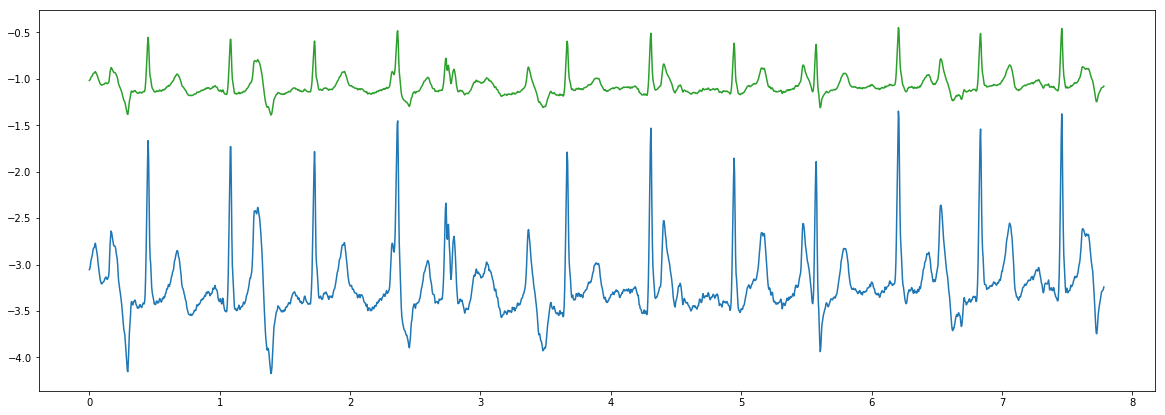

In [62]:
merged = (raw[:,0] + raw[:,1] + raw[:,2])
t = np.linspace(0,len(merged)/fs,len(merged))

fig, ax = plt.subplots(2,0,figsize=(20,7), sharex=False, sharey=False)
plt.plot(t[:2001], merged[:2001], ax[0])

plt.plot(t[:2001], merged[:2001]/3, ax[1])

merged.shape

## Use the gqrs detection algorithm and correct the peaks

In [66]:
def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()

In [69]:
# Use the gqrs algorithm to detect qrs locations in the first channel
qrs_inds = processing.gqrs_detect(sig=merged[:2001], fs=record.fs)
qrs_inds

array([ 107,  270,  435,  599,  695,  858,  942, 1098, 1263, 1424, 1587,
       1671, 1756, 1916])

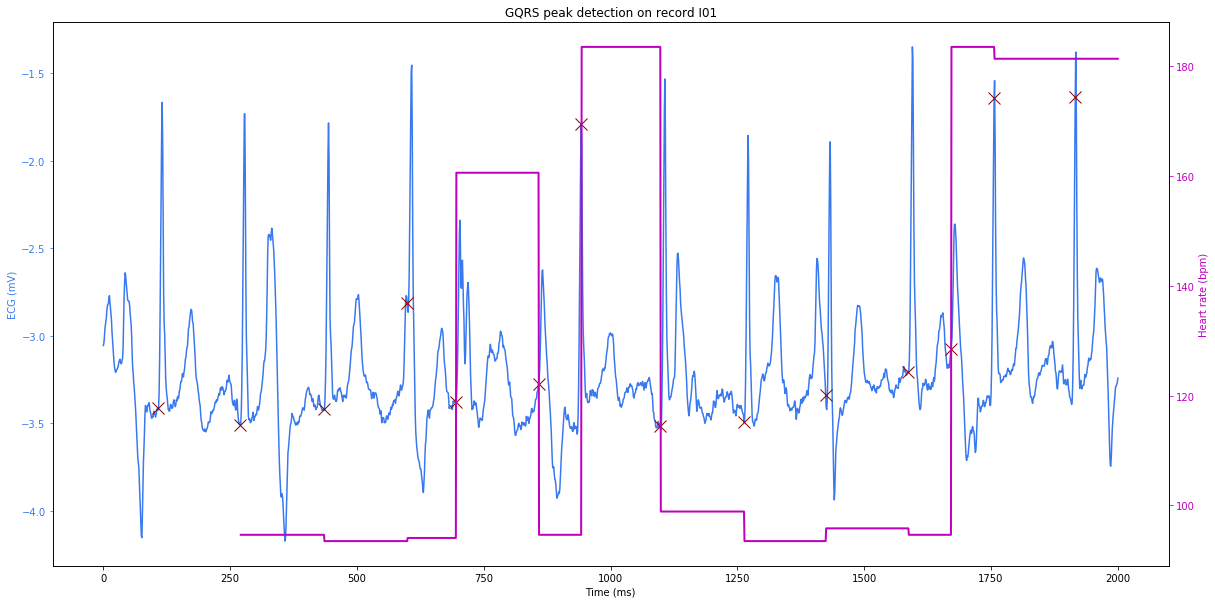

In [71]:
# Plot results
peaks_hr(sig=merged[:2001], peak_inds=qrs_inds, fs=record.fs,
        title="GQRS peak detection on record I01")
    

In [ ]:
# Correct the peaks shifting them to local maxima
min_bpm = 20
max_bpm = 230
#min_gap = record.fs * 60 / min_bpm
# Use the maximum possible bpm as the search radius
search_radius = int(record.fs * 60 / max_bpm)
corrected_peak_inds = processing.correct_peaks(merged, peak_inds=qrs_inds,
                                               search_radius=search_radius, smooth_window_size=150)

# Display results
print('Corrected gqrs detected peak indices:', sorted(corrected_peak_inds))
peaks_hr(sig=merged, peak_inds=sorted(corrected_peak_inds), fs=record.fs,
         title="Corrected GQRS peak detection on record I01")

## Use the xqrs detection algorithm and compare results to reference annotations

/home/singuyen/anaconda3/envs/biosignal/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/singuyen/anaconda3/envs/biosignal/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/singuyen/anaconda3/envs/biosignal/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` inst

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
11 reference annotations, 11 test annotations

True Positives (matched samples): 10
False Positives (unmatched test samples: 1
False Negatives (unmatched reference samples): 1

Specificity: 0.9091 (10/11)
Positive Predictivity: 0.9091 (10/11)
False Positive Rate: 0.0909 (1/11)


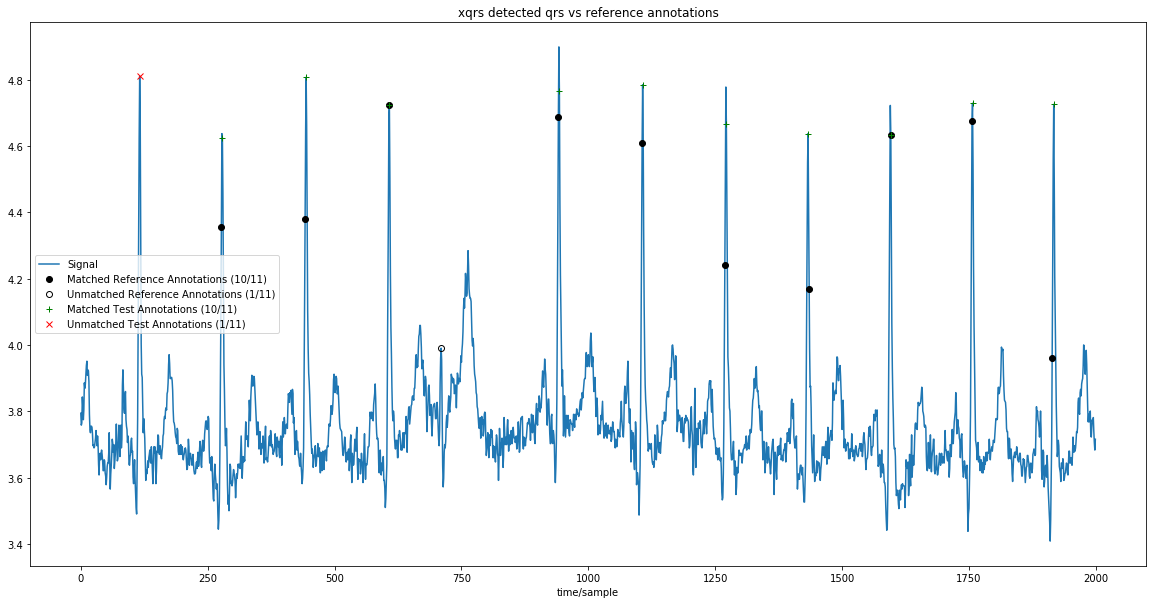

In [75]:
sig, fields = wfdb.rdsamp('../rawData/I01', channels=[0], sampto=2000)
ann_ref = wfdb.rdann('../rawData/I01','atr', sampto=2000)

# Run qrs detection on signal
xqrs = processing.XQRS(sig=sig[:,0], fs=fields['fs'])
xqrs.detect()
# Alternatively, use the gateway function to get the qrs indices directly
# qrs_inds = processing.xqrs_detect(sig=sig[:,0], fs=fields['fs'])

# Compare detected qrs complexes to reference annotation.
# Note, first sample in 100.atr is not a qrs.
comparitor = processing.compare_annotations(ref_sample=ann_ref.sample[1:],
                                            test_sample=xqrs.qrs_inds,
                                            window_width=int(0.1 * fields['fs']),
                                            signal=sig[:,0])

# Print and plot the results
comparitor.print_summary()
comparitor.plot(title='xqrs detected qrs vs reference annotations', figsize=(20,10))